In [1]:
import torch
from config_loader import load_config, get_model_name
from datasets import load_dataset
from plotting import plot_conditioned_examples

config = load_config("SCVAE1D")
# Load dataset
train_loader, val_loader, test_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

x, x_cond, y = next(iter(train_loader))

In [2]:
from lightning_extensions import ExtendedTrainer
from modules import VAEModule

model = VAEModule(config['model_params'], model_name=config['model_name'])

trainer = ExtendedTrainer(project_name="MultiTaskVariationalAutoecnoders_test", **config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which wi

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Home/siv34/edzak2974/projects/MastersThesis/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type | Params
-------------------------------
0 | model | VAE  | 811 K 
-------------------------------
811 K     Trainable params
0         Non-trainable params
811 K     Total params
3.245     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 68.11it/s, v_num=fpb5, train_recon_loss=2.87e+3, train_kl_loss=530.0, train_loss=3.4e+3, val_recon_loss=3.68e+3, val_kl_loss=714.0, val_loss=4.39e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 68.08it/s, v_num=fpb5, train_recon_loss=2.87e+3, train_kl_loss=530.0, train_loss=3.4e+3, val_recon_loss=3.68e+3, val_kl_loss=714.0, val_loss=4.39e+3]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_kl_loss,▅▁▃▃▄▆▄▄▅▅▆▅▇▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇██▇███
train_loss,█▇▅▅▄▆▅▃▃▅▃▂▃▂▂▃▂▂▂▂▂▃▃▂▁▃▂▁▂▂▂▂▂▁▂▂▁▃▁▂
train_recon_loss,█▇▅▅▅▆▅▄▃▅▃▂▃▂▂▃▂▃▃▂▂▃▂▂▂▃▂▁▂▂▂▂▂▁▂▂▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_kl_loss,▁▃▄▄▅▅▅▆▆▆▆▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████
val_loss,▇▆█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recon_loss,█▆█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_kl_loss,529.97742
train_loss,3398.0166


VAE([128, 256]_2)?dataset=MNIST&batch_size=128&max_epochs=50


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


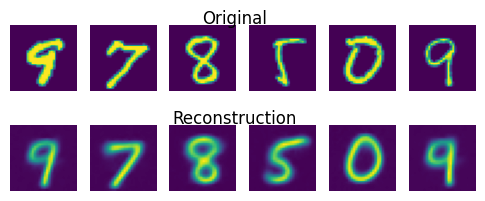

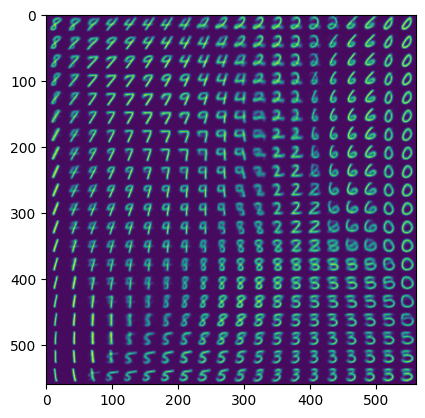

In [2]:
from modules import VAEModule
print(model_name)
model = VAEModule.load_model_checkpoint(model_name = model_name)
model.eval()
from plotting import plot_stage_one_results
# plot some samples and their reconstruction

plot_stage_one_results(model, test_loader)